# Design of Digital Filters

*This jupyter/Python notebook is part of a [collection of notebooks](../index.ipynb) in the masters module [Digital Signal Processing](http://www.int.uni-rostock.de/Digitale-Signalverarbeitung.48.0.html), Comunications Engineering, Universität Rostock. Please direct questions and suggestions to <mailto:Sascha.Spors@uni-rostock.de>.*

## Example: Non-Recursive versus Recursive Filter

In the following example, the characteristics and computational complexity of a non-recursive and a recursive filter are compared for a particular design. Quantization is not considered. In order to design the filters we need to specify the requirements. This is typically done by a *tolerance scheme*. The scheme states the desired frequency response and allowed deviations. This is explained at an example.

We aim at the design of a low-pass filter with 

1. unit amplitude with an allowable symmetric deviation of $\delta_\text{p}$ for $|\Omega| < \Omega_\text{p}$
2. an attenuation of $a_\text{s}$ for $|\Omega| > \Omega_\text{s}$

where the indices p and s denote the pass- and stop-band, respectively. The region between the pass-band $\Omega_\text{p}$ and the stop-band $\Omega_\text{s}$ is known as *transition-band*. The phase of the filter is not specified.

The resulting tolerance scheme is illustrated for the design parameters $\Omega_\text{p} = \frac{\pi}{3}$, $\Omega_\text{s} = \frac{\pi}{3} + 0.05$, $\delta_\text{p} = 1.5$ dB and $a_\text{s} = -60$ dB.

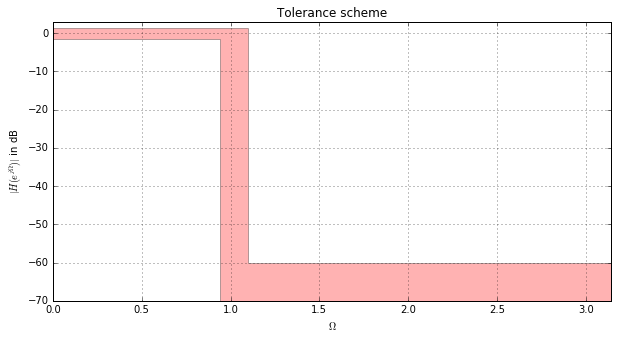

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.signal as sig

def plot_tolerance_scheme(Omp, Oms, d_p, a_s):
    Omp = Omp * np.pi
    Oms = Oms * np.pi

    p = [[0, -d_p], [Omp, -d_p], [Omp, -300], [np.pi, -300], [np.pi, a_s], [Oms, a_s], [Oms, d_p], [0, d_p]]
    polygon = mpatches.Polygon(p, closed=True, facecolor='r', alpha=0.3)
    plt.gca().add_patch(polygon)


Omp = .3  # normalized corner frequency of pass-band
Oms = .3 + 0.05  # normalized corner frequency of stop-band
d_p = 1.5  # one-sided pass-band ripple in dB
a_s = -60  # stop-band attenuation in dB

plt.figure(figsize = (10, 5))
plot_tolerance_scheme(Omp, Oms, d_p, a_s)
plt.title('Tolerance scheme')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.axis([0, np.pi, -70, 3])
plt.grid();

**Exercise**

* What corner frequencies $f_\text{p}$ and $f_\text{s}$ result for a sampling frequency of $f_\text{s} = 48$ kHz?

The comparison of non-recursive and recursive filters depends heavily on the chosen filter design algorithm. For the design of the non-recursive filter a technique is used which bases on numerical optimization of the filter coefficients with respect to the desired response. The [Remez algorithm](https://en.wikipedia.org/wiki/Remez_algorithm), as implemented in `scipy.signal.remez`, is used for this purpose. The parameters for the algorithm are the corner frequencies of the pass- and stop-band, as well as the desired attenuation in the stop-band. For the recursive filter, a [Chebyshev type II](https://en.wikipedia.org/wiki/Chebyshev_filter) design is used. Here the parameters are the corner frequency and attenuation of the stop-band. The order of both filters has been chosen manually to fit the given tolerance scheme.

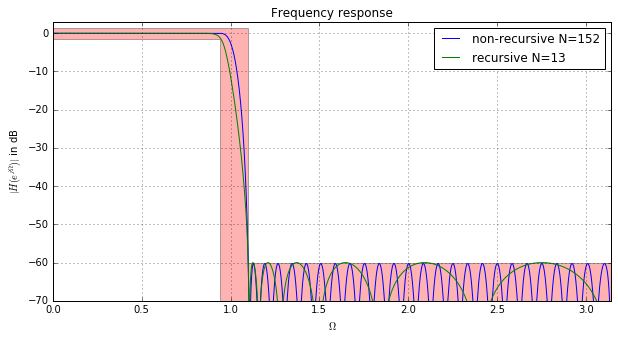

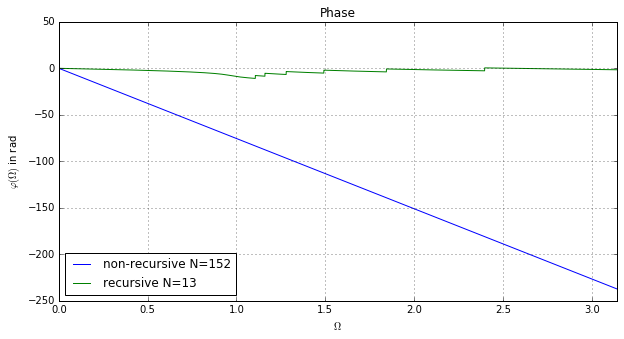

In [2]:
N = 152  # length of non-recursive filter
M = 13  # order of recursive filter

# design of non-recursive filter
h = sig.remez(N, [0, Omp/2, Oms/2, 1/2], [1, 10**((a_s-5)/20)], weight=[1, 1])

# design of recursive filter
b, a = sig.cheby2(M, -a_s, Oms)

# compute frequency response of filter
Om, Hn = sig.freqz(h, worN=8192)
Om, Hr = sig.freqz(b, a, worN=8192)

# plot frequency response
plt.figure(figsize = (10,5))
plt.plot(Om, 20*np.log10(np.abs(Hn)), 'b-', label=r'non-recursive N=%d'%N)
plt.plot(Om, 20*np.log10(np.abs(Hr)), 'g-', label=r'recursive N=%d'%M)
plot_tolerance_scheme(Omp, Oms, d_p, a_s)
plt.title('Frequency response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend()
plt.axis([0, np.pi, -70, 3])
plt.grid()
# plot phase
plt.figure(figsize = (10,5))
plt.plot(Om, np.unwrap(np.angle(Hn)), label=r'non-recursive N=%d'%N)
plt.plot(Om, np.unwrap(np.angle(Hr)), label=r'recursive N=%d'%M)
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi(\Omega)$ in rad')
plt.legend(loc=3)
plt.xlim([0, np.pi])
plt.grid()

**Exercises**

* How do both designs differ in terms of their magnitude and phase responses?
* Calculate the number of multiplications and additions required to realize the non-recursive filter
* Calculate the number of multiplications and additions required to realize the recursive filter in [transposed direct form II](../recursive_filters/direct_forms.ipynb#Transposed-Direct-Form-II)
* Decrease the corner frequencies and adapt the order of the filters to match the tolerance scheme

In order to evaluate the computational complexity of both filters, the execution time is measured when filtering a signal $x[k]$ of length $L=10^5$ samples. The non-recursive filter is realized by direct convolution, the recursive filter in transposed direct form II using the respective Python functions. 

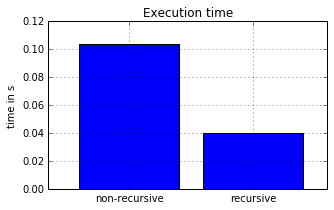

In [3]:
import timeit

reps = 20  # number of repetitions for timeit

# setup environment for timeit
tsetup = 'import numpy as np; import scipy.signal as sig; from __main__ import h, a, b; x=np.random.normal(size=1e5)'
# non-recursive filter
tn = timeit.timeit('np.convolve(x, h, "full")', setup=tsetup, number=reps)
# recursive filter
tr = timeit.timeit('sig.lfilter(b, a, x)' , setup=tsetup, number=reps)

# show the results
plt.figure(figsize = (5, 3))
plt.bar(1, tn)
plt.bar(2, tr)
plt.title('Execution time')
plt.xticks([1.4, 2.4], ('non-recursive', 'recursive'))
plt.ylabel('time in s')
plt.xlim([.75, 3])
plt.grid()

**Exercises**

* Do the execution times correspond with the number of algorithmic operations calculated in the previous exercise?
* Estimate the computational load for the filtering of a signal with a sampling rate of 48 kHz
* How could the execution time of the non-recursive filter be decreased?
* Finally, would you prefer the non-recursive or the recursive design for a practical implementation? Consider the numerical complexity, as well as numerical aspects in your decision.

**Copyright**

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>